In [2]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid, NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx
import powerlaw

random.seed(133)
np.random.seed(133)

**FUNCTIONS AND CLASSES**

In [3]:
def weighted_average(history, decay=0.8):
    weights = [decay**i for i in range(len(history)-1, -1, -1)]
    weights = np.array(weights) / sum(weights)
    return np.sum(np.array(history) * weights)

def compute_avalanches(series, delta=0.01):
    return np.diff(series)[np.diff(series) > delta]


class Household(Agent):
    def __init__(self, unique_id, model, P, C0, alpha, bin_id):
        super().__init__(unique_id, model)
        self.P, self.C0, self.alpha, self.bin_id = P, C0, alpha, bin_id
        self.lambda_param = model.lambda_param
        self.local_random = np.random.RandomState(model.seed + unique_id)
        self.logit = model.logit
        self.memory_length = model.memory_length
        self.rho_history = deque(maxlen=self.memory_length)
        self.deltaC_history = deque(maxlen=self.memory_length)
        self.decay = model.decay
        self.s = self.random.random() < 0.5
        self.hat_rho = 0.0
        self.hat_deltaC = 0.0
        self.rho = 0.0
        self.deltaC = 0.0

    def step(self):
        if self.rho_history:
            self.hat_rho = weighted_average(self.rho_history, decay=self.decay)
        if self.deltaC_history:
            self.hat_deltaC = weighted_average(self.deltaC_history, decay=self.decay)
        U_R = self.P - (self.C0 + self.hat_deltaC) + self.alpha * self.hat_rho
        U_N = - self.alpha * self.hat_rho
        if self.logit:
            m = max(U_R, U_N)
            exp_R = math.exp((U_R - m) * self.lambda_param)
            exp_N = math.exp((U_N - m) * self.lambda_param)
            p_R = exp_R / (exp_R + exp_N)
            self.s = (self.local_random.random() < p_R)
        else:
            self.s = U_R > U_N

    def advance(self):
        neigh_ids = self.model.net.get_neighbors(self.unique_id)
        self.rho = np.mean([self.model.households[j].s for j in neigh_ids]) if neigh_ids else 0.0
        if self.s:
            self.model.bins[self.bin_id].Q_m += 1
        self.rho_history.append(self.rho)
        self.deltaC_history.append(self.deltaC)

class Bin(Agent):
    def __init__(self, unique_id, model, K_m, pos):
        super().__init__(unique_id, model)
        self.K_m, self.Q_m, self.pos = K_m, 0, pos
    def step(self): pass
    def advance(self): pass

class RecyclingModel(Model):
    def __init__(self, N=100, L=10, M=9, k=4, delta=0.5, c=0.3, kappa=0.05,
                 epsilon=0.05, alpha=0.4, K_default=10, memory_length=10,
                 logit=False, lambda_param=1.0, seed=133, activation='random', decay=0.8):
        super().__init__()

        # Store model parameters first so they're available to agents
        self.seed = seed
        self.random = np.random.RandomState(self.seed)
        self.num_agents, self.grid_size, self.num_bins = N, L, M
        self.delta, self.c, self.kappa, self.epsilon = delta, c, kappa, epsilon
        self.alpha, self.K_default = alpha, K_default
        self.memory_length = memory_length
        self.logit = logit
        self.lambda_param = lambda_param
        self.decay = decay

        # Network and grid
        self.G = nx.barabasi_albert_graph(n=N, m=max(1, k // 2), seed=self.random.randint(1e9))
        self.net = NetworkGrid(self.G)
        self.grid = MultiGrid(width=L, height=L, torus=False)
        self.schedule = SimultaneousActivation(self)

        # Create bins
        self.households, self.bins = {}, {}
        bin_positions = [(x, y) for x in [2, 5, 8] for y in [2, 5, 8]]
        for m, (x_m, y_m) in enumerate(bin_positions):
            bin_id = N + m
            bin_agent = Bin(bin_id, self, K_default, (x_m, y_m))
            self.bins[m] = bin_agent
            self.grid.place_agent(bin_agent, (x_m, y_m))
            self.schedule.add(bin_agent)

        # Assign household coordinates
        coords = [(i, j) for i in range(L) for j in range(L)][:N]
        P_vals = np.random.rand(N)
        champions = self.random.choice(N, size=int(epsilon * N), replace=False)
        for i in champions:
            P_vals[i] = 2.0

        # Create households
        for i in range(N):
            x_i, y_i = coords[i]
            dists = [np.linalg.norm(np.array((x_i, y_i)) - np.array(self.bins[m].pos)) for m in self.bins]
            bin_id = int(np.argmin(dists))
            C0_i = 0.0 if i in champions else c + kappa * dists[bin_id]
            agent = Household(i, self, P_vals[i], C0_i, 1.0 if i in champions else alpha, bin_id)
            self.households[i] = agent
            self.schedule.add(agent)
            self.grid.place_agent(agent, coords[i])
            self.net.place_agent(agent, i)

        # Initialize social info
        for i, agent in self.households.items():
            neigh_ids = self.net.get_neighbors(i)
            agent.rho = np.mean([self.households[j].s for j in neigh_ids]) if neigh_ids else 0.0
            agent.deltaC = 0.0
            agent.hat_rho = agent.rho
            agent.hat_deltaC = 0.0

        # Data collection
        self.datacollector = DataCollector(
            model_reporters={
                "Global_Recycle_Rate": lambda m: np.mean([h.s for h in m.households.values()]),
                "Average_Rho": lambda m: np.mean([h.rho for h in m.households.values()]),
                "Overloaded_Bins": lambda m: sum(1 for b in m.bins.values() if b.Q_m > b.K_m)
            },
            agent_reporters={"Strategy": lambda a: a.s if isinstance(a, Household) else None}
        )

    def step(self):
        for b in self.bins.values():
            b.Q_m = 0
        self.schedule.step()
        for agent in self.households.values():
            bin_agent = self.bins[agent.bin_id]
            agent.deltaC = self.delta * max(0, bin_agent.Q_m - bin_agent.K_m)
        self.datacollector.collect(self)


**RECYCLING RATE PLOT**

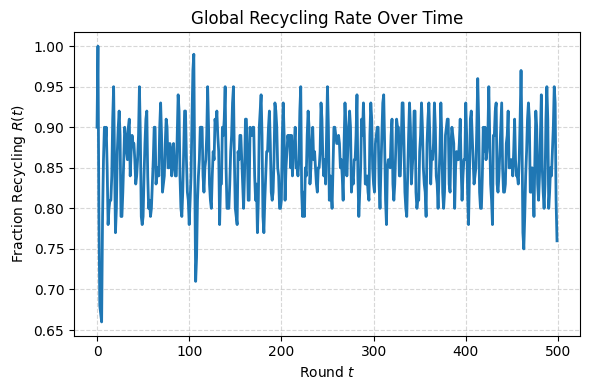

Final fraction recycling R(T) = 0.760
Average over last 10 rounds   = 0.853
Min fraction recycling        = 0.660
Max fraction recycling        = 1.000


In [4]:
random.seed(133)
np.random.seed(133)

model = RecyclingModel(
    N=100, L=10, M=9, k=4, delta=0.7, c=0.3, kappa=0.05,
    epsilon=0.05, alpha=0.5, K_default=10, memory_length=100,
    logit=True, lambda_param=20, activation='simultaneous', decay=0.8
)

T = 500
for _ in range(T):
    model.step()

model_data = model.datacollector.get_model_vars_dataframe()

# plot global recycling rate over time
plt.figure(figsize=(6, 4))
plt.plot(model_data["Global_Recycle_Rate"], lw=2)
plt.xlabel("Round $t$")
plt.ylabel("Fraction Recycling $R(t)$")
plt.title("Global Recycling Rate Over Time")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/recycling_rate_over_time.png", dpi=300)
plt.show()

print(f"Final fraction recycling R(T) = {model_data['Global_Recycle_Rate'].iloc[-1]:.3f}")
print(f"Average over last 10 rounds   = {model_data['Global_Recycle_Rate'].iloc[-10:].mean():.3f}")
print(f"Min fraction recycling        = {model_data['Global_Recycle_Rate'].min():.3f}")
print(f"Max fraction recycling        = {model_data['Global_Recycle_Rate'].max():.3f}")


**AVALANCHE COMPUTATION AND THEN PLOT**

In [6]:
def compute_avalanches(series, delta=0.01):
    return np.diff(series)[np.diff(series) > delta]

params = dict(
    N=200, L=15, M=9, k=4,
    delta=0.5, c=0.3, kappa=0.05, epsilon=0.05,
    alpha=3.73871, K_default=10, memory_length=100,
    logit=True, lambda_param=30, activation='simultaneous', decay=0.9
)

all_avalanches = []
seeds = range(5)

for seed in seeds:
    params['seed'] = seed
    m = RecyclingModel(**params)
    r_series = []
    for t in range(1000):
        m.step()
        if t > 100:
            r_series.append(np.mean([h.s for h in m.households.values()]))
    aval = compute_avalanches(r_series, delta=0.01)
    all_avalanches.extend(aval)

print(f"Total avalanches detected: {len(all_avalanches)}")


Total avalanches detected: 458


**ATTEMPT TO FIT POWERLAW (with some statistical analysis)**

c:\Users\Utente\AppData\Local\Programs\Python\Python310\lib\site-packages\powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


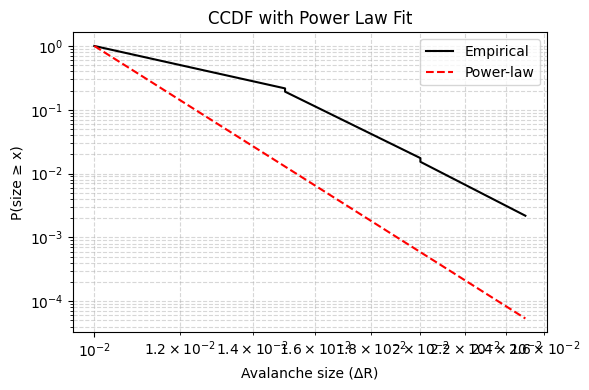

Power law exponent: 11.7346
Xmin: 0.0100
KS distance: 0.2033

Log-likelihood ratio R (vs lognormal): -0.8687
p-value (vs lognormal): 2.9769e-01

Log-likelihood ratio R (vs exponential): 65.2346
p-value (vs exponential): 9.2477e-39


In [7]:
if all_avalanches:
    fit = powerlaw.Fit(all_avalanches, xmin=0.01)

    alpha = fit.power_law.alpha
    xmin = fit.power_law.xmin
    ks = fit.power_law.KS()

    R_ln, p_ln = fit.distribution_compare('power_law', 'lognormal')
    R_exp, p_exp = fit.distribution_compare('power_law', 'exponential')


    fig, ax = plt.subplots(figsize=(6, 4))
    fit.plot_ccdf(ax=ax, label='Empirical', color='black')
    fit.power_law.plot_ccdf(ax=ax, color='red', linestyle='--', label='Power-law')
    plt.xlabel("Avalanche size (ΔR)")
    plt.ylabel("P(size ≥ x)")
    plt.title("CCDF with Power Law Fit")
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig("figures/avalanches_ccdf_powerlaw.png", dpi=300)
    plt.show()

    print(f"Power law exponent: {alpha:.4f}")
    print(f"Xmin: {xmin:.4f}")
    print(f"KS distance: {ks:.4f}")
    print(f"\nLog-likelihood ratio R (vs lognormal): {R_ln:.4f}")
    print(f"p-value (vs lognormal): {p_ln:.4e}")
    print(f"\nLog-likelihood ratio R (vs exponential): {R_exp:.4f}")
    print(f"p-value (vs exponential): {p_exp:.4e}")
else:
    print("No avalanches detected. Try lowering delta or adjusting model parameters.")


Total parameter combinations: 243


Grid Search Progress:  90%|████████▉ | 218/243 [9:40:26<1:10:06, 168.25s/it]c:\Users\Utente\AppData\Local\Programs\Python\Python310\lib\site-packages\powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Grid Search Progress:  92%|█████████▏| 223/243 [9:54:52<57:12, 171.62s/it]  'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Grid Search Progress:  95%|█████████▍| 230/243 [10:14:52<37:52, 174.84s/it]'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calc

Top parameter set:
lambda_param    30.00000
alpha            3.73871
delta            0.50000
epsilon          0.05000
decay            0.90000
Name: 223, dtype: float64


KeyError: 'alpha'

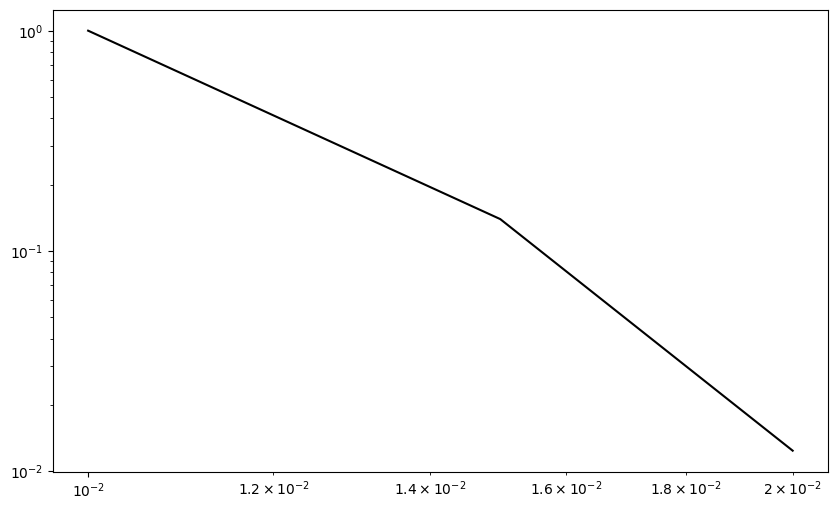

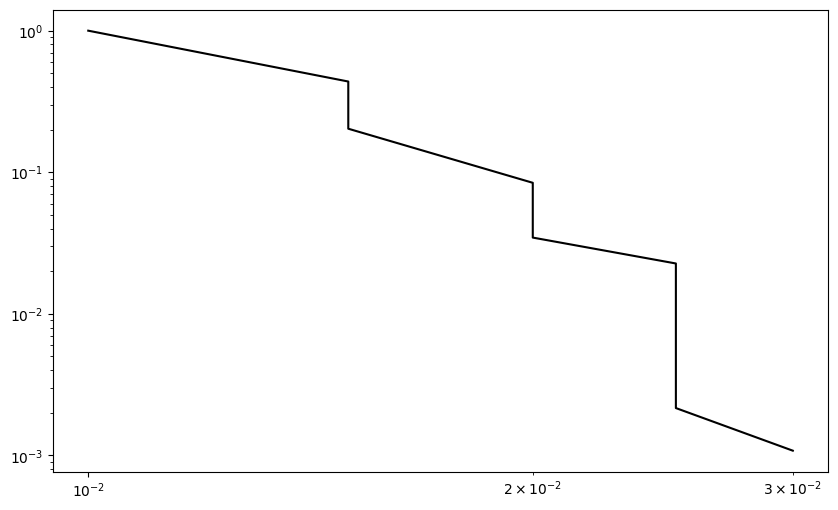

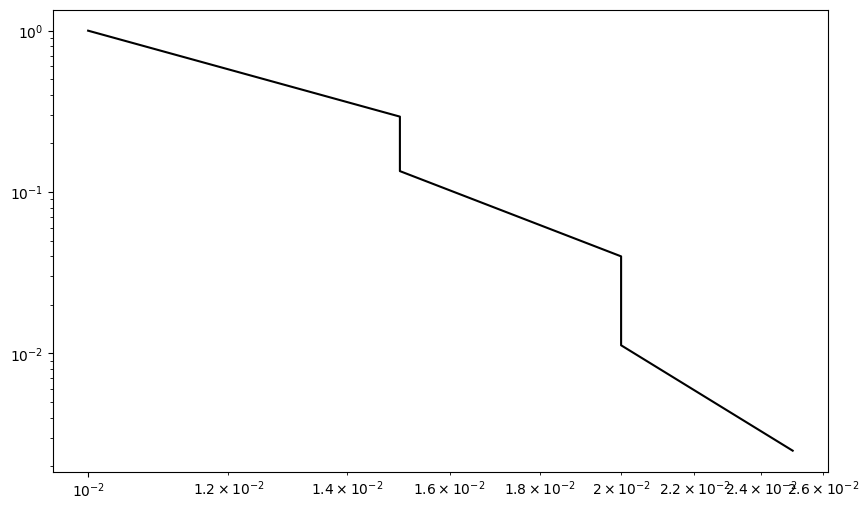

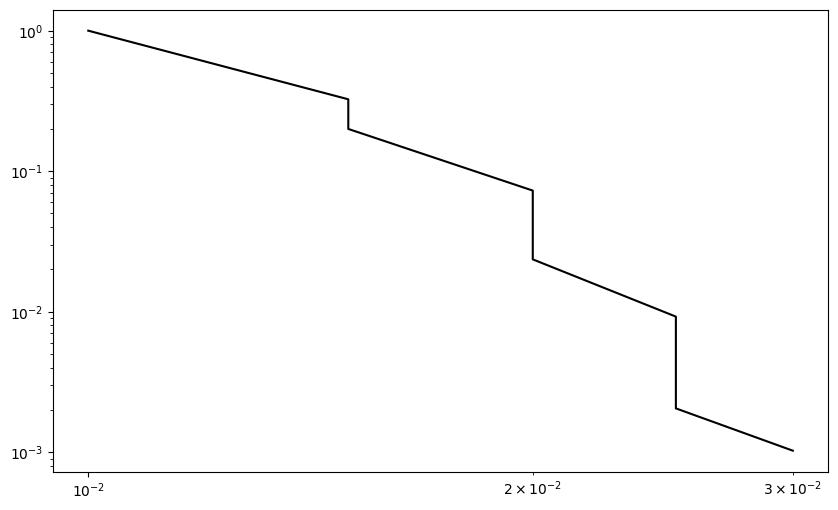

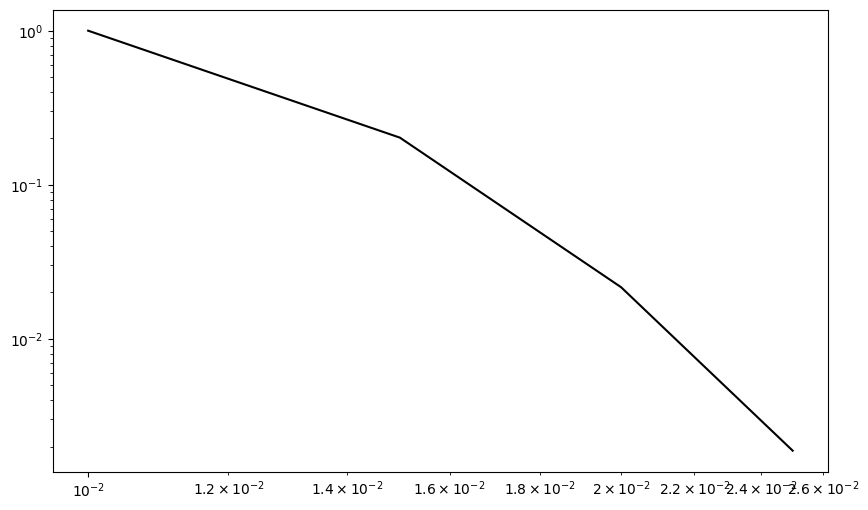

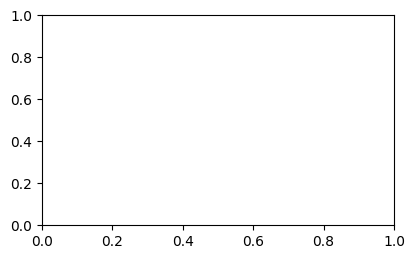

In [ ]:
import numpy as np
import pandas as pd
import powerlaw
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import os

# Create directory for results
os.makedirs('grid_search_results', exist_ok=True)

# Define the parameter grid
param_grid = {
    'lambda_param': [10, 20, 30],
    'alpha': [0.4, 0.6, 0.8],
    'delta': [0.5, 0.7, 0.9],
    'epsilon': [0.01, 0.03, 0.05],
    'decay': [0.8, 0.9, 0.95]
}

# Fixed parameters
fixed_params = {
    'N': 200,
    'L': 15,
    'M': 9,
    'k': 4,
    'c': 0.3,
    'kappa': 0.05,
    'K_default': 10,
    'memory_length': 100,
    'logit': True,
    'activation': 'simultaneous'
}

# Generate all parameter combinations
param_combinations = list(itertools.product(*param_grid.values()))
print(f"Total parameter combinations: {len(param_combinations)}")

# Function to compute avalanches
def compute_avalanches(series, delta=0.01):
    """Detect significant increases in recycling rate"""
    return np.diff(series)[np.diff(series) > delta]

# Function to evaluate power-law fit
def evaluate_powerlaw_fit(avalanches):
    """Evaluate power-law fit and return metrics"""
    if len(avalanches) < 50:
        return {'alpha': np.nan, 'xmin': np.nan, 'ks': np.nan,
                'R_ln': np.nan, 'p_ln': np.nan,
                'R_exp': np.nan, 'p_exp': np.nan,
                'num_avalanches': len(avalanches)}
    
    try:
        fit = powerlaw.Fit(avalanches, xmin=np.min(avalanches))
        alpha = fit.power_law.alpha
        xmin = fit.power_law.xmin
        ks = fit.power_law.KS()
        
        R_ln, p_ln = fit.distribution_compare('power_law', 'lognormal')
        R_exp, p_exp = fit.distribution_compare('power_law', 'exponential')
        
        return {
            'alpha': alpha,
            'xmin': xmin,
            'ks': ks,
            'R_ln': R_ln,
            'p_ln': p_ln,
            'R_exp': R_exp,
            'p_exp': p_exp,
            'num_avalanches': len(avalanches)
        }
    except:
        return {'alpha': np.nan, 'xmin': np.nan, 'ks': np.nan,
                'R_ln': np.nan, 'p_ln': np.nan,
                'R_exp': np.nan, 'p_exp': np.nan,
                'num_avalanches': len(avalanches)}

# Main grid search function
def run_grid_search(param_combinations, fixed_params, num_seeds=3, steps=4000, burn_in=1000):
    """Run grid search over parameter combinations"""
    results = []
    
    for i, params_tuple in enumerate(tqdm(param_combinations, desc="Grid Search Progress")):
        # Create parameter dictionary
        params_dict = dict(zip(param_grid.keys(), params_tuple))
        full_params = {**fixed_params, **params_dict}
        
        all_avalanches = []
        
        # Run multiple seeds for each parameter set
        for seed in range(num_seeds):
            full_params['seed'] = seed
            model = RecyclingModel(**full_params)
            
            # Run simulation
            r_series = []
            for t in range(steps):
                model.step()
                if t >= burn_in:  # Skip burn-in period
                    r_series.append(np.mean([h.s for h in model.households.values()]))
            
            # Compute avalanches
            aval = compute_avalanches(r_series, delta=0.01)
            all_avalanches.extend(aval)
        
        # Evaluate power-law fit
        fit_metrics = evaluate_powerlaw_fit(np.array(all_avalanches))
        
        # Save results
        result_entry = {
            **params_dict,
            **fit_metrics,
            'num_seeds': num_seeds
        }
        results.append(result_entry)
        
        # Periodically save intermediate results
        if (i + 1) % 10 == 0 or (i + 1) == len(param_combinations):
            df = pd.DataFrame(results)
            df.to_csv('grid_search_results/grid_search_intermediate.csv', index=False)
    
    return pd.DataFrame(results)

# Run the grid search
results_df = run_grid_search(param_combinations, fixed_params)

# Save final results
results_df.to_csv('grid_search_results/grid_search_results.csv', index=False)

# Analysis: Find best parameter sets
def find_best_fits(df):
    """Identify best parameter sets based on power-law fit quality"""
    # Filter out runs with insufficient avalanches
    df = df[df['num_avalanches'] >= 50]
    
    # Calculate composite score (higher is better)
    df['score'] = (
        (df['R_ln'] > 0) * (df['p_ln'] < 0.05) * 1 + 
        (df['R_exp'] > 0) * (df['p_exp'] < 0.05) * 1 +
        (1 / df['ks']) * 0.5
    )
    
    # Sort by score and power-law exponent
    df = df.sort_values(by=['score', 'alpha'], ascending=[False, True])
    
    return df

# Analyze results
best_fits_df = find_best_fits(results_df)

# Save best fits
best_fits_df.to_csv('grid_search_results/best_fits.csv', index=False)

# Plot results for top parameter sets
def plot_top_results(best_fits_df, top_n=5):
    """Plot results for top parameter sets"""
    for i, (_, row) in enumerate(best_fits_df.head(top_n).iterrows()):
        params = {**fixed_params, **row[list(param_grid.keys())].to_dict()}
        all_avalanches = []
        
        # Re-run to collect avalanches for plotting
        for seed in range(3):
            params['seed'] = seed
            model = RecyclingModel(**params)
            r_series = []
            for t in range(4000):
                model.step()
                if t >= 1000:
                    r_series.append(np.mean([h.s for h in model.households.values()]))
            aval = compute_avalanches(r_series, delta=0.01)
            all_avalanches.extend(aval)
        
        # Fit and plot
        fit = powerlaw.Fit(np.array(all_avalanches), xmin=np.min(all_avalanches))
        plt.figure(figsize=(10, 6))
        fit.plot_ccdf(label='Empirical', color='black')
        fit.power_law.plot_ccdf(label='Power-law fit', linestyle='--', color='red')
        
        # Format plot
        param_str = "\n".join([f"{k}: {v}" for k, v in row[list(param_grid.keys())].items()])
        plt.title(f"Top Fit #{i+1}\n{param_str}")
        plt.xlabel("Avalanche Size")
        plt.ylabel("CCDF")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f'grid_search_results/top_fit_{i+1}.png', dpi=150)
        plt.close()

# Generate plots for top results
if not best_fits_df.empty:
    plot_top_results(best_fits_df)
    print(f"Top parameter set:\n{best_fits_df.iloc[0][list(param_grid.keys())]}")
else:
    print("No good power-law fits found. Consider adjusting parameters.")

# Additional analysis: Parameter sensitivity
def analyze_parameter_sensitivity(results_df):
    """Analyze how parameters affect power-law fit quality"""
    sensitivity = {}
    
    for param in param_grid.keys():
        plt.figure(figsize=(10, 6))
        
        # Group by parameter value
        grouped = results_df.groupby(param).mean()
        
        # Plot effect on power-law exponent
        plt.subplot(2, 2, 1)
        grouped['alpha'].plot(marker='o')
        plt.title(f'Effect on Power-law Exponent')
        plt.ylabel('Alpha')
        
        # Plot effect on KS distance
        plt.subplot(2, 2, 2)
        grouped['ks'].plot(marker='o')
        plt.title(f'Effect on KS Distance')
        plt.ylabel('KS Distance')
        
        # Plot effect on lognormal comparison
        plt.subplot(2, 2, 3)
        grouped['R_ln'].plot(marker='o')
        plt.title(f'Effect vs Lognormal')
        plt.ylabel('R (Positive favors power-law)')
        
        # Plot effect on exponential comparison
        plt.subplot(2, 2, 4)
        grouped['R_exp'].plot(marker='o')
        plt.title(f'Effect vs Exponential')
        plt.ylabel('R (Positive favors power-law)')
        
        plt.tight_layout()
        plt.savefig(f'grid_search_results/sensitivity_{param}.png', dpi=150)
        plt.close()
        
        sensitivity[param] = grouped
    
    return sensitivity

# Run sensitivity analysis
sensitivity_results = analyze_parameter_sensitivity(results_df)
print("Sensitivity analysis complete.")

**EXPLORE OTHER FITS (with their respective statistical analysis)**

Assuming nested distributions


Assuming nested distributions
Power law exponent: 1.7668
Xmin: 0.0100
KS distance: 0.2777

Log-likelihood ratio R (vs lognormal): -760.1505
p-value (vs lognormal): 0.0000e+00

Log-likelihood ratio R (vs exponential): -772.9224
p-value (vs exponential): 0.0000e+00

Log-likelihood ratio R (vs truncated power-law): -512.8052
p-value (vs truncated power-law): 0.0000e+00

Truncated power-law exponent α: 1.0000
Truncated λ: 12.3547
Lognormal μ: -3.3476, σ: 0.6677


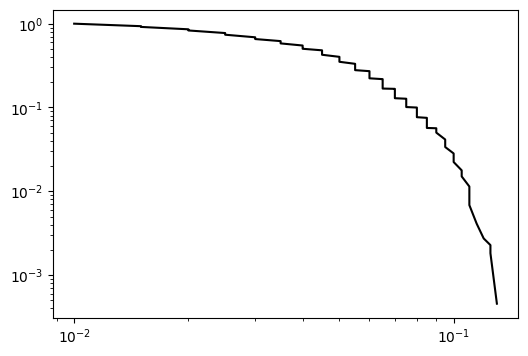

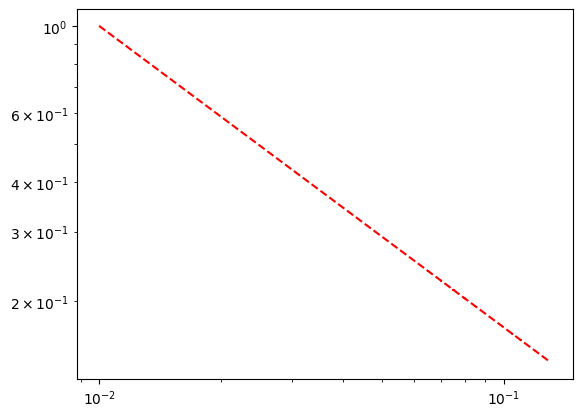

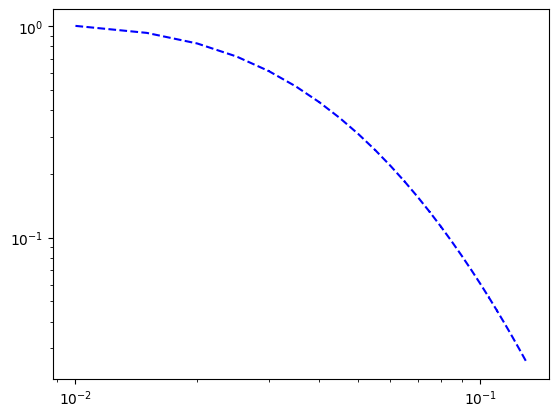

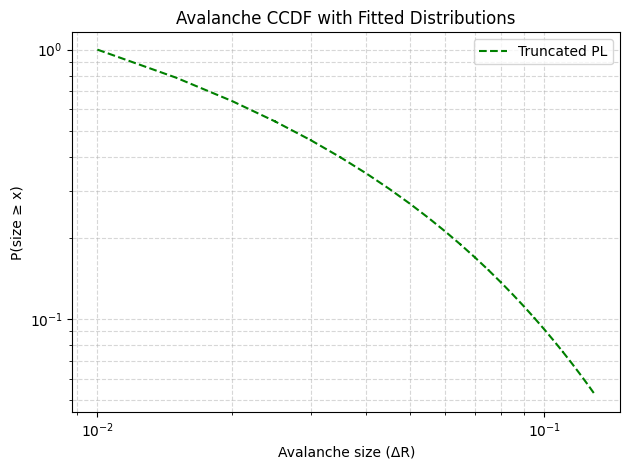

In [ ]:
data = np.array(all_avalanches)
fit = powerlaw.Fit(data, xmin=0.01)


alpha = fit.power_law.alpha
xmin = fit.power_law.xmin
ks_distance = fit.power_law.KS()

# alternative distribution parameters
lognormal_mu = fit.lognormal.mu
lognormal_sigma = fit.lognormal.sigma
trunc_alpha = fit.truncated_power_law.alpha
trunc_lambda = fit.truncated_power_law.parameter2 

# compare distributions (assuming nesting)
# I didnt notice any difference with assuming nesting = False
R_ln, p_ln = fit.distribution_compare('power_law', 'lognormal', nested=True)
R_exp, p_exp = fit.distribution_compare('power_law', 'exponential', nested=True)
R_trunc, p_trunc = fit.distribution_compare('power_law', 'truncated_power_law', nested=True)

# results
print("Assuming nested distributions")
print(f"Power law exponent: {alpha:.4f}")
print(f"Xmin: {xmin:.4f}")
print(f"KS distance: {ks_distance:.4f}")
print()
print(f"Log-likelihood ratio R (vs lognormal): {R_ln:.4f}")
print(f"p-value (vs lognormal): {p_ln:.4e}")
print()
print(f"Log-likelihood ratio R (vs exponential): {R_exp:.4f}")
print(f"p-value (vs exponential): {p_exp:.4e}")
print()
print(f"Log-likelihood ratio R (vs truncated power-law): {R_trunc:.4f}")
print(f"p-value (vs truncated power-law): {p_trunc:.4e}")
print()
print(f"Truncated power-law exponent α: {trunc_alpha:.4f}")
print(f"Truncated λ: {trunc_lambda:.4f}")
print(f"Lognormal μ: {lognormal_mu:.4f}, σ: {lognormal_sigma:.4f}")

# plots
plt.figure(figsize=(6, 4))
fit.plot_ccdf(label='Empirical', color='black')
fit.power_law.plot_ccdf(color='red', linestyle='--', label='Power-law')
fit.lognormal.plot_ccdf(color='blue', linestyle='--', label='Lognormal')
fit.truncated_power_law.plot_ccdf(color='green', linestyle='--', label='Truncated PL')
plt.xlabel("Avalanche size (ΔR)")
plt.ylabel("P(size ≥ x)")
plt.title("Avalanche CCDF with Fitted Distributions")
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("figures/avalanches_ccdf_fits.png", dpi=300)
plt.show()